# Task 1

In [2]:
import sys
import os
sys.path.append("../") # go to parent dir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bct import normalize
from itertools import combinations
from scipy.stats import false_discovery_control

from my_src.utils import load_connectome 
from my_src.clinical_group import ClinicalGroup 
from my_src.statistics import compute_max_t_stat, permutation_testing
from my_src import constants

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp

%load_ext autoreload
%autoreload 2

figures_folder = "../writeup/figures/"

In [3]:
group_connectomes = dict()

clinical_groups = dict()
# Load connectomes for each clinical group
for name in constants.clinical_group_names:
    clinical_groups[name] = ClinicalGroup(name)


Error computing diffusion_efficiency for participant LMCI:40 - Singular matrix
Error computing diffusion_efficiency for participant DEM:24 - Singular matrix


In [4]:
lmci_40_connectome = clinical_groups["LMCI"].connectomes[40].copy()
lmci_40_connectome_min_weight = np.min(lmci_40_connectome[np.nonzero(lmci_40_connectome)])
print("participant LMCI:40's smallest non-zero weight:", "{:.2e}".format(lmci_40_connectome_min_weight))
dem_24_connectome = clinical_groups["DEM"].connectomes[24].copy()
dem_24_connectome_min_weight = np.min(dem_24_connectome[np.nonzero(dem_24_connectome)])
print("participant DEM:24's smallest non-zero weight:", "{:.2e}".format(dem_24_connectome_min_weight))

participant LMCI:40's smallest non-zero weight: 3.02e-05
participant DEM:24's smallest non-zero weight: 3.99e-05


In [5]:
print("metrics:",list(constants.metric_functions.keys()))
print("groups:",constants.clinical_group_names)
tau_region_list = pd.read_csv("../data/TauRegionList.csv")
print(tau_region_list.columns.to_list())

metrics: ['node_strength', 'clustering_coefficient', 'density', 'global_efficiency', 'diffusion_efficiency']
groups: ['CN', 'EMCI', 'LMCI', 'DEM']
['Raj_label', 'FS_LUT', 'FS_label']


## Comparing the Metrics

In [6]:
def get_lowest_p_value_metric(df_metric_kw_p_values, metric_name):
    """
    Given a dictionary of metrics' p-values, 
    return the region with the lowest p-value for a specified metric that's computed per-node.
    """
    # Extract node_strength items
    node_strength_metrics = df_metric_kw_p_values[df_metric_kw_p_values.metric.apply(lambda x: x.startswith(metric_name))]

    # Find node_strength with lowest p-value
    min_p_value = node_strength_metrics["p-value"].min()
    min_p_node_idx = node_strength_metrics["p-value"].idxmin()
    min_p_node_name = node_strength_metrics.loc[min_p_node_idx]["metric"]
    return min_p_node_name, min_p_value

def compute_kw_p_values(clinical_groups):
    "given a list of clinical groups, compute the p-values for each metric"
    metric_p_values = {}
    metrics_to_plot = clinical_groups["CN"].metrics.keys()
    group_names = constants.clinical_group_names

    for metric_name in metrics_to_plot:
        data_list = []
        for group in group_names:
            metrics = clinical_groups[group].metrics[metric_name]
            metrics = metrics[~np.isnan(metrics)]
            data_list.append(metrics)
        # Perform Kruskal-Wallis test (non-parametric ANOVA)
        h_stat, p_value = stats.kruskal(*data_list)
        metric_p_values[metric_name] = p_value
    df_metric_p_values = pd.DataFrame.from_dict(metric_p_values, orient='index', columns=['p-value'])\
                            .reset_index()\
                                .rename(columns={"index": "metric"})
    return df_metric_p_values

In [7]:
df_metric_kw_p_values = compute_kw_p_values(clinical_groups)
metrics_to_plot = constants.global_metrics.copy()
for metric in constants.node_level_metrics:
    min_p_node_name, _ = get_lowest_p_value_metric(df_metric_kw_p_values, metric)
    metrics_to_plot.append(f"{metric} (avg)")
    metrics_to_plot.append(min_p_node_name)
    
df_metrics_to_plot = df_metric_kw_p_values[df_metric_kw_p_values.metric.isin(metrics_to_plot)]

/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_2326/288339641.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df, ax=ax, palette=custom_palette)
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_2326/288339641.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df, ax=ax, palette=custom_palette)
/var/folders/6d/4tg2mcn17jl13prtz8kyzwk40000gn/T/ipykernel_2326/288339641.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='Value', data=df, ax=ax, pale

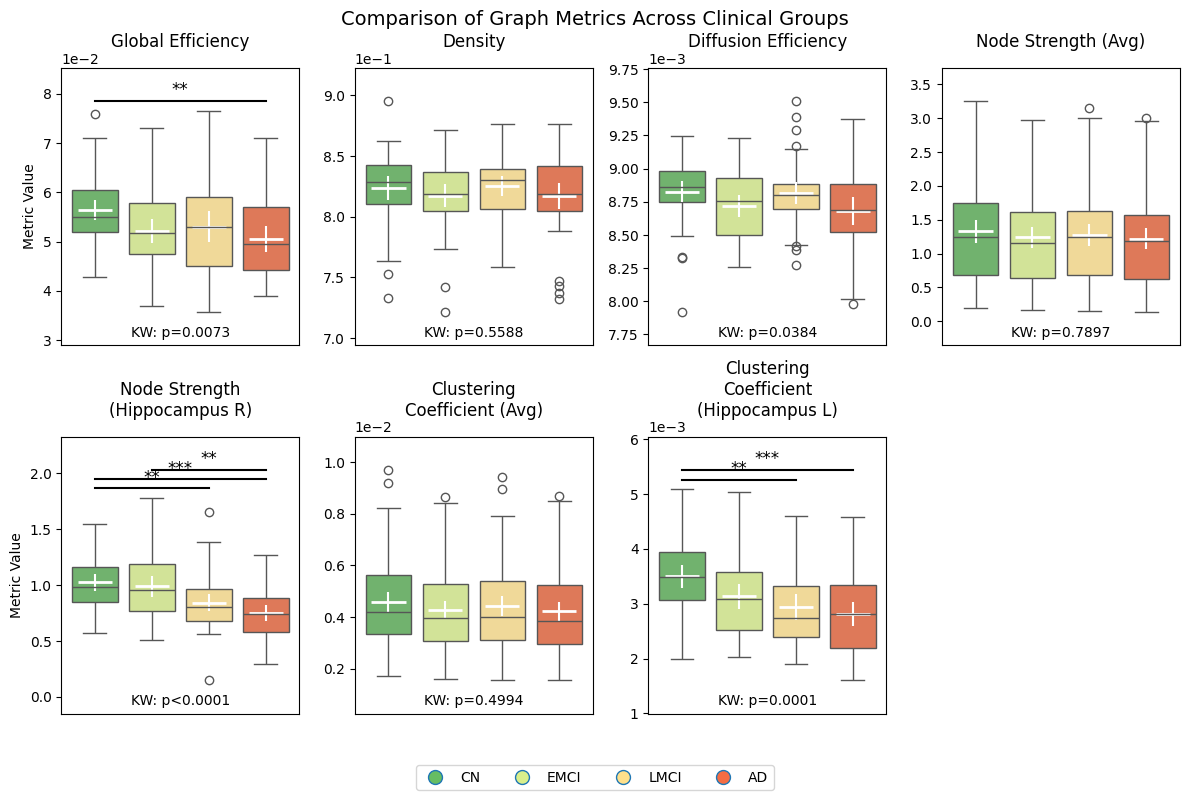

Significant pairwise comparisons:

global_efficiency:
  CN vs DEM: p=0.0043 **

node_strength (Hippocampus_R):
  CN vs LMCI: p=0.0051 **
  CN vs DEM: p=0.0000 ***
  EMCI vs DEM: p=0.0014 **

clustering_coefficient (Hippocampus_L):
  CN vs LMCI: p=0.0019 **
  CN vs DEM: p=0.0002 ***


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp
import textwrap
import os

def compute_statistics(metric_name, clinical_groups, group_names=constants.clinical_group_names):
    """
    Compute statistical tests for a metric across clinical groups.
    
    Returns:
        tuple: (dataframe of values, p-value of Kruskal-Wallis test, list of significant pairs)
    """
    # Collect data for this metric
    data = []
    labels = []
    
    for group in group_names:
        metric_values = clinical_groups[group].metrics[metric_name]
        # Remove NaN values
        metric_values = metric_values[~np.isnan(metric_values)]
        data.append(metric_values)
        labels.extend([group] * len(metric_values))
    
    # Create DataFrame for analysis
    all_values = np.concatenate(data)
    df = pd.DataFrame({'Group': labels, 'Value': all_values})
    
    # Perform Kruskal-Wallis test
    h_stat, p_value = stats.kruskal(*data)
    
    # If significant, perform post-hoc tests
    significant_pairs = []
    if p_value < 0.05:
        # Create DataFrame for Dunn's test
        dunn_df = pd.DataFrame({
            'value': all_values,
            'group': labels
        })
        
        # Perform Dunn's test for pairwise comparisons
        dunn_result = sp.posthoc_dunn(dunn_df, val_col='value', group_col='group', p_adjust='bonferroni')
        
        # Get significant pairs
        for i1, g1 in enumerate(group_names):
            for i2, g2 in enumerate(group_names):
                if i1 < i2:  # Only lower triangle
                    p = dunn_result[g1][g2]
                    if p < 0.05:
                        significant_pairs.append((g1, g2, p))
    
    return df, p_value, significant_pairs

def create_metric_plot(ax, df, p_value, significant_pairs, metric_name, 
                       group_names=constants.clinical_group_names, 
                       custom_palette=constants.clinical_group_colors_map):
    """
    Create a strip plot for a metric with statistics and significance indicators.
    """
    # Create the strip plot
    sns.boxplot(x='Group', y='Value', data=df, ax=ax, palette=custom_palette)
    
    # Add horizontal lines showing mean and 95% CI for each group
    for j, group in enumerate(group_names):
        group_data = df[df['Group'] == group]['Value']
        if len(group_data) > 0:
            mean = group_data.mean()
            ci_low, ci_high = stats.t.interval(
                0.95, len(group_data)-1, loc=mean, scale=stats.sem(group_data)
            ) if len(group_data) > 1 else (mean, mean)
            
            # Plot mean line
            ax.hlines(y=mean, xmin=j-0.3, xmax=j+0.3, colors='white', linestyles='-', lw=2)
            
            # Plot 95% CI
            ax.vlines(x=j, ymin=ci_low, ymax=ci_high, colors='white', linestyles='-', lw=1.5)
    
    # Add significance indicators
    if significant_pairs:
        y_max = df['Value'].max()
        y_range = df['Value'].max() - df['Value'].min()
        
        for k, (g1, g2, p) in enumerate(significant_pairs):
            g1_idx = group_names.index(g1)
            g2_idx = group_names.index(g2)
            
            # Determine significance level marker
            if p < 0.001:
                sig_marker = '***'
            elif p < 0.01:
                sig_marker = '**'
            elif p < 0.05:
                sig_marker = '*'
            
            # Calculate y position for the bar (staggered if multiple)
            y_pos = y_max + 0.05 * y_range * (k + 1)
            
            # Draw the bar
            ax.plot([g1_idx, g2_idx], [y_pos, y_pos], 'k-', linewidth=1.5)
            ax.text((g1_idx + g2_idx) / 2, y_pos + 0.01 * y_range, sig_marker, 
                    ha='center', va='bottom', color='black', fontsize=12)
    
    # Wrap title to allow two lines if too long
    metric_display = metric_name.replace('_', ' ').replace('(', '(').replace(')', ')').title()
    metric_display = textwrap.fill(metric_display, width=20)
    # Set title with a fixed pad and center alignment for consistent positioning
    ax.set_title(metric_display, fontsize=12, loc='center', pad=15)
    
    # Remove x-axis labels (ticks and text)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', bottom=False)
    ax.set_xlabel('')
    
    # Format y-axis in scientific notation
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    # extend bottom y-axis limit to make room for p-value
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min - 0.1  * (y_max - y_min), y_max + 0.1  * (y_max - y_min))    
    # Add Kruskal-Wallis p-value to the plot (placed in the lower part of the axes)
    p_text = f'KW: p={p_value:.4f}' if p_value >= 0.0001 else f'KW: p<0.0001'
    ax.text(0.5, 0.02, p_text, ha='center', va='bottom', transform=ax.transAxes, fontsize=10)

# Main code
# List of metrics and groups
metrics = metrics_to_plot

# Set up the figure with subplots
n_metrics = len(metrics)
n_cols = 4
n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Dictionary to store p-values for significant comparisons
all_significant_pairs = {}

# Loop through metrics and create strip plots
for i, metric_name in enumerate(metrics):
    if i >= len(axes):
        break
        
    ax = axes[i]
    
    # Compute statistics
    df, p_value, significant_pairs = compute_statistics(metric_name, clinical_groups)
    all_significant_pairs[metric_name] = significant_pairs
    
    # Create plot for the current metric
    create_metric_plot(ax, df, p_value, significant_pairs, metric_name)
    
    # Set y-label only for leftmost plots
    if i % n_cols == 0:
        ax.set_ylabel('Metric Value', fontsize=10)
    else: 
        ax.set_ylabel('')

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout with a specified rectangle to leave room for the overall title and legend
plt.tight_layout(rect=(0, 0.07, 1, 0.97))
plt.subplots_adjust(bottom=0.1)

# Add a title for the entire figure
fig.suptitle('Comparison of Graph Metrics Across Clinical Groups', fontsize=14, y=0.98)

# Create a legend for clinical groups (cognitive stage)
handles = [plt.Line2D([], [], marker='o', linestyle='', markersize=10, 
                      markerfacecolor=constants.clinical_group_colors_map[group], label=constants.clinical_group_name_map[group])
           for group in constants.clinical_group_names]
fig.legend(handles=handles, loc='lower center', ncol=len(constants.clinical_group_names), fontsize=10)

# Save the figure with high resolution appropriate for a scientific paper
plt.savefig(os.path.join(figures_folder, 'graph_metrics_comparison.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# Print out all significant pairwise comparisons
print("Significant pairwise comparisons:")
for metric, pairs in all_significant_pairs.items():
    if pairs:
        print(f"\n{metric}:")
        for g1, g2, p in pairs:
            stars = '***' if p < 0.001 else '**' if p < 0.01 else '*'
            print(f"  {g1} vs {g2}: p={p:.4f} {stars}")

In [ ]:
clinical_groups["CN"].metrics[]

{'CN': <my_src.clinical_group.ClinicalGroup at 0x13db11590>,
 'EMCI': <my_src.clinical_group.ClinicalGroup at 0x10a3135d0>,
 'LMCI': <my_src.clinical_group.ClinicalGroup at 0x138268590>,
 'DEM': <my_src.clinical_group.ClinicalGroup at 0x12803ab90>}

In [15]:
# Print out all significant pairwise comparisons and prepare a LaTeX table
print("Significant pairwise comparisons:")
print("\\begin{table}[ht]")
print("    \\centering")
print("    \\small")
print("    \\caption{Significant pairwise comparisons between clinical groups}")
print("    \\label{tab:significant_comparisons}")
print("    \\begin{tabular}{lllrrrc}")
print("        \\toprule")
print("        \\textbf{Metric} & \\textbf{Group 1} & \\textbf{Group 2} & \\textbf{Mean 1} & \\textbf{Mean 2} & \\textbf{\\% Diff} & \\textbf{p-value} \\\\")
print("        \\midrule")

for metric, pairs in all_significant_pairs.items():
    if pairs:
        for g1, g2, p in pairs:
            # Calculate means for each group
            mean1 = clinical_groups[g1].metrics[metric].mean()
            mean2 = clinical_groups[g2].metrics[metric].mean()
            
            # Calculate percentage difference
            pct_diff = (mean2 - mean1) / mean1 * 100
            
            # Format p-value with stars
            if p < 0.001:
                p_formatted = f"$<$0.001***"
            elif p < 0.01:
                p_formatted = f"{p:.3f}**"
            else:
                p_formatted = f"{p:.3f}*"
                
            # Format metric name for display
            metric_display = metric.replace('_', ' ').title()
            
            # Print table row
            print(f"        {metric_display} & {g1} & {g2} & {mean1:.2e} & {mean2:.2e} & {pct_diff:.1f}\\% & {p_formatted} \\\\")

print("        \\bottomrule")
print("    \\end{tabular}")
print("\\end{table}")

Significant pairwise comparisons:
\begin{table}[ht]
    \centering
    \small
    \caption{Significant pairwise comparisons between clinical groups}
    \label{tab:significant_comparisons}
    \begin{tabular}{lllrrrc}
        \toprule
        \textbf{Metric} & \textbf{Group 1} & \textbf{Group 2} & \textbf{Mean 1} & \textbf{Mean 2} & \textbf{\% Diff} & \textbf{p-value} \\
        \midrule
        Global Efficiency & CN & DEM & 5.64e-02 & 5.05e-02 & -10.3\% & 0.004** \\
        Node Strength (Hippocampus R) & CN & LMCI & 1.03e+00 & 8.43e-01 & -17.9\% & 0.005** \\
        Node Strength (Hippocampus R) & CN & DEM & 1.03e+00 & 7.52e-01 & -26.8\% & $<$0.001*** \\
        Node Strength (Hippocampus R) & EMCI & DEM & 9.88e-01 & 7.52e-01 & -23.9\% & 0.001** \\
        Clustering Coefficient (Hippocampus L) & CN & LMCI & 3.50e-03 & 2.94e-03 & -15.9\% & 0.002** \\
        Clustering Coefficient (Hippocampus L) & CN & DEM & 3.50e-03 & 2.81e-03 & -19.7\% & $<$0.001*** \\
        \bottomrule
    \en